<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/speedup/sdxlturbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [ ]:
!pip install diffusers transformers accelerate --upgrade

Load model

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

# パイプラインの準備
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

In [ ]:
%%time

# プロンプトの準備
prompt = "cute cat ear maid, super detailed, best quality"
negative_prompt = "worst quality, bad arms, bad anatomy, bad faces, bad hands"

# 画像生成
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=1,
    guidance_scale=0.0
).images[0]

# 確認
display(image)

Img2Img

In [ ]:
!wget https://www.toho-ent.co.jp/wp-content/uploads/2021/10/2021-10-27_09-59-50_225736-1024x682.jpg -O /content/nagasawa.jpg

In [ ]:
from diffusers import AutoPipelineForImage2Image
from PIL import Image
import torch

pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")


In [ ]:
init_image = Image.open("/content/nagasawa.jpg").convert("RGB")
size = init_image.size
init_image = init_image.resize((512, 512))

prompt = "cute cat ear maid, super detailed, best quality"
negative_prompt = "worst quality, bad arms, bad anatomy, bad faces, bad hands"

image = pipe(prompt, negative_prompt=negative_prompt, image=init_image, num_inference_steps=2, strength=0.5, guidance_scale=0.0).images[0]
display(image.resize(size))

ControlNet

In [12]:
!pip install -q controlnet_aux safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.0 MB/s eta 0:00:00


In [1]:

import torch
from PIL import Image

from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from transformers import DPTFeatureExtractor, DPTForDepthEstimation


depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/sdxl-turbo",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
import numpy as np
def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(512, 512),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

  0%|          | 0/2 [00:00<?, ?it/s]

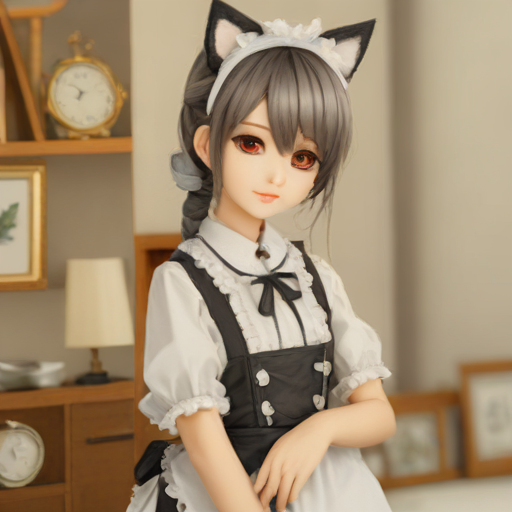

In [3]:
prompt = "cute cat ear maid, super detailed, best quality"
negative_prompt = "worst quality, bad arms, bad anatomy, bad faces, bad hands"
init_image = Image.open("/content/nagasawa.jpg").convert("RGB")
controlnet_conditioning_scale = 0.5  # recommended for good generalization

depth_image = get_depth_map(init_image)

image = pipe(
    prompt, negative_prompt=negative_prompt, image=depth_image, num_inference_steps=2, guidance_scale=0.0, controlnet_conditioning_scale=controlnet_conditioning_scale,
).images[0]

display(image)
